In [2]:
# --- 1️⃣ Setup and Load Data ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load your same SKU data (the cleaned one)
df = pd.read_csv("supply_chain_dataset1.csv")

sku_id = "SKU_1"
df_sku = df[df["SKU_ID"] == sku_id].copy()
df_sku = df_sku.sort_values("Date")

# Convert Date to datetime
df_sku["Date"] = pd.to_datetime(df_sku["Date"])

# Prophet expects columns: ds (date) and y (target)
prophet_df = df_sku[["Date", "Units_Sold"]].rename(columns={"Date": "ds", "Units_Sold": "y"})

# Train-test split (last 10% for test)
n = len(prophet_df)
holdout_size = int(0.1 * n)
train_df = prophet_df.iloc[:-holdout_size]
test_df = prophet_df.iloc[-holdout_size:]

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (1643, 2), Test shape: (182, 2)


In [3]:
import pmdarima as pm
print(pm.__version__) # Optional: Print the installed version

2.0.4


In [4]:

# --- 6️⃣ Train ARIMA ---
train_series = train_df['y']
test_series = test_df['y']

# Auto ARIMA chooses best (p,d,q)
model_arima = pm.auto_arima(
    train_series,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore"
)

print(model_arima.summary())
print("✅ ARIMA model trained successfully")

/home/hamza/Documents/Envirnments/dsenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hamza/Documents/Envirnments/dsenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hamza/Documents/Envirnments/dsenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hamza/Documents/Envirnments/dsenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hamza/Documents/Envirnments/dsenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: F

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1643
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -5111.083
Date:                Mon, 20 Oct 2025   AIC                          10226.166
Time:                        15:43:47   BIC                          10236.973
Sample:                             0   HQIC                         10230.173
                               - 1643                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9544      0.008   -124.357      0.000      -0.969      -0.939
sigma2        29.5500      0.958     30.831      0.000      27.671      31.429
Ljung-Box (L1) (Q):                   0.04   Jarque-

/home/hamza/Documents/Envirnments/dsenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/hamza/Documents/Envirnments/dsenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/hamza/Documents/Envirnments/dsenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📊 ARIMA MAE: 5.2323, RMSE: 6.4669


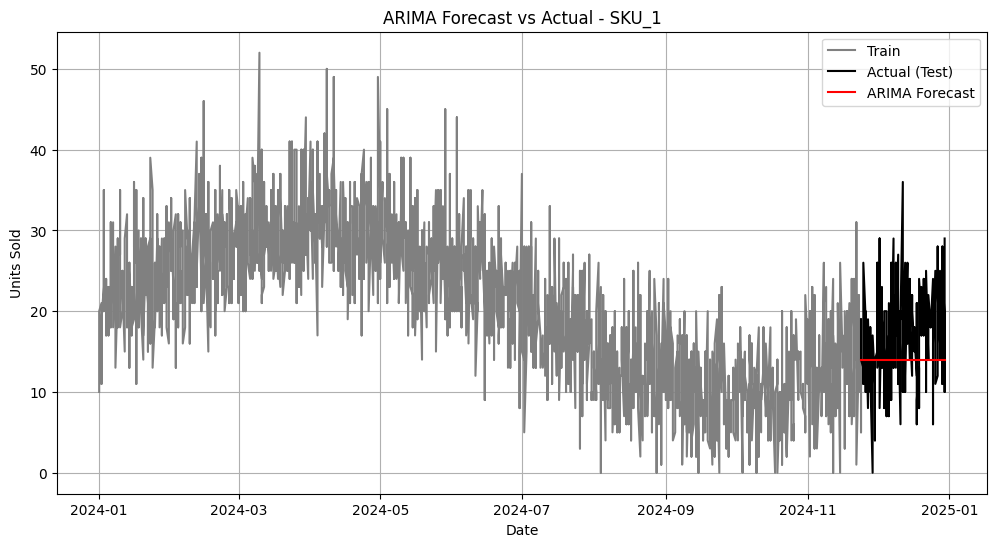

In [5]:
# --- 7️⃣ Forecast and Evaluate ARIMA ---
forecast_arima = model_arima.predict(n_periods=len(test_series))

mae_arima = mean_absolute_error(test_series, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test_series, forecast_arima))

print(f"📊 ARIMA MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(train_df['ds'], train_series, label='Train', color='gray')
plt.plot(test_df['ds'], test_series, label='Actual (Test)', color='black')
plt.plot(test_df['ds'], forecast_arima, label='ARIMA Forecast', color='red')
plt.title(f'ARIMA Forecast vs Actual - {sku_id}')
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.show()